# Preprocessing of the probability map of divisions using a Gaussian filter and a Distance Transform Watershed segmentation of fission sites

In [1]:
%gui qt5

In [207]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
import napari
from skimage import filters, morphology, segmentation, feature, measure
from skimage.color import label2rgb
from skimage.util import compare_images
from skimage.io import imread, imsave
import scipy.ndimage as ndi

import h5py   # HDF5 data file management library
from glob import glob
from tqdm.notebook import tqdm

In [3]:
def save_h5(data, path, name):
  filename = path+name+'.h5'
  print('Saving '+filename)
  hf = h5py.File(filename, 'a')
  hf= hf.create_dataset(name, data=data)
  
def load_h5(path, name):
  filename = path+name+'.h5'
  print('\nLoading '+filename)
  hf = h5py.File(filename, 'r').get(name)
  print('Converting to array')
  return np.array(hf)

In [4]:
def plot_comparison(input_img, output_img, cmap = ['gray', 'inferno'],
                    labels=['input_data', 'output_data'], frame=None, merge=False, axes=None):
  title_size = 20
  
  if merge:
    if axes is None:
      fig, axes = plt.subplots(1, 3, figsize=(5*3, 5))
    if frame is not None:
      axes[2].set_title('merge[%i]'%frame, size=title_size)
    else:
      axes[2].set_title('merge', size=title_size)
    axes[2].imshow(input_img, cmap=cmap[0])
    axes[2].imshow(output_img, cmap=cmap[1], alpha=0.5)
    axes[2].set(xticks=[], yticks=[])
    axes[2].axis('off')
  
  else:
    if axes is None:
      fig, axes = plt.subplots(1, 2, figsize=(5*2, 5))
  
  for ax, img, c, title in zip(axes[:2], [input_img, output_img], 
                               cmap, labels[:2]):
    if frame is not None:
      ax.set_title(title+'[%i]'%frame, size=title_size)
    else:
      ax.set_title(title, size=title_size)
    ax.imshow(img, cmap=c)
    ax.axis('off')
  
  plt.subplots_adjust(wspace=0.05)
  return axes

In [190]:
def distance_watershed(img):
  """Segmentation of events of interest based on Distance Transform Watershed 
  of the Hessian probability map of divisions"""
  distance = ndi.distance_transform_edt(img)
  #Division sites as makers
  coords = feature.peak_local_max(distance, labels=img>0)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords.T)] = True
  markers = ndi.label(mask)[0]
  #Watershed
  return segmentation.watershed(-distance, markers, mask=img)

def prepareProc(img, threshold=0, vmax=255):
  """Smoothed probability map of divisions"""
  labels = distance_watershed(img)  
  labels = segmentation.clear_border(labels)
  img2 = np.zeros_like(img)
  if len(np.unique(labels))>1: #Pixels above the threshold and not in contact with the border
    # Gaussian dilation to increase minimal spot size
    rp = measure.regionprops(labels)
    centroids = np.array([region.centroid for region in rp]).round().astype(int)
    mask = (centroids[:, 0], centroids[:, 1])
    img2[mask] = img[mask]
    img2 = filters.gaussian(img2, 2)
    #Normalization
    img2 = img2*vmax/img2.max()
  return img2

def prepareStack(stack, **kwargs):
  if stack.ndim == 2:
    return prepareProc(stack, **kwargs)
  procStack = np.zeros_like(stack)
  for i, img in tqdm(enumerate(stack)):
    procStack[i] = prepareProc(img, **kwargs)
  return procStack

## Import input and output data

In [142]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

proc_output_data = load_h5(data_path, 'WatProc')
print('Processed outputs:', proc_output_data.shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/WatProc.h5
Converting to array
Processed outputs: (37000, 128, 128)


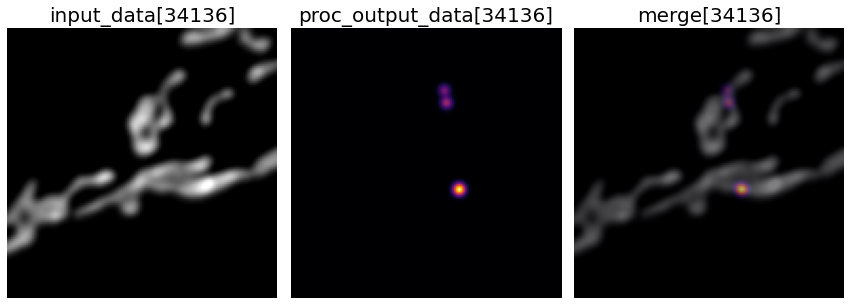

In [143]:
nb_examples = 2
#item_id = np.random.randint(low=0, high=output_data.shape[0]-1, size=nb_examples)
item_id = [34136]
labels = ['input_data', 'proc_output_data']
for input_img, output_img, frame in zip(input_data[item_id], proc_output_data[item_id], item_id):
  plot_comparison(input_img, output_img, frame=frame, merge=True, labels=labels)

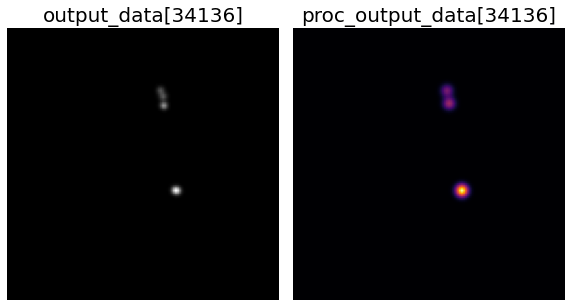

In [8]:
labels = ['output_data', 'proc_output_data']
for input_img, output_img, frame in zip(output_data[item_id], output_data[item_id], item_id):
  plot_comparison(input_img, prepareStack(output_img), labels=labels, frame=frame)

In [9]:
blending = 'additive'
opacity = 0.7

cmap = {'input_data': 'gray', 'output_data': 'red', 'proc_output_data': 'inferno'}
gamma_output = 0.2

viewer = napari.Viewer()
viewer.add_image(input_data, colormap=cmap['input_data'], 
                 blending=blending, opacity=opacity, name='Mito')
viewer.add_image(output_data, colormap=cmap['output_data'], 
                 blending=blending, gamma=gamma_output, name='Output')
viewer.add_image(proc_output_data, colormap=cmap['proc_output_data'], 
                 blending=blending, gamma=gamma_output, name='Proc. output')

AttributeError: 'LooseVersion' object has no attribute 'version'

C:\Users\snrodrig\Anaconda3\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'Proc. output' at 0xf7ae041f40>

c


In [118]:
def counter(binary_output):
    N = len(binary_output)
    yes_counts = np.sum(binary_output)
    no_counts = N-yes_counts
    return 100*yes_counts/N, 100*no_counts/N

In [119]:
#Check how many yes/no images there are.
division_mask = proc_output_data!=0
binary_output = (np.any(np.any(division_mask, axis=1), axis=1))
print('Yes: %.2f%%\nNo: %.2f%%'%counter(binary_output))

Yes: 64.88%
No: 35.12%


In [120]:
nb_img = input_data.shape[0]
mean_output_data = np.zeros(nb_img)
for frame in tqdm(np.where(binary_output_data)[0]):
  mean_output_data[frame] = np.mean(proc_output_data[frame])

window_size = 5
mean_output_threshold = 0.5
filtered_mean_output = ndi.median_filter(mean_output_data, size=window_size)
filtered_binary_output = filtered_mean_output>mean_output_threshold
print('Yes: %.2f%%\nNo: %.2f%%'%counter(filtered_binary_output))

  0%|          | 0/24004 [00:00<?, ?it/s]

Yes: 18.89%
No: 81.11%


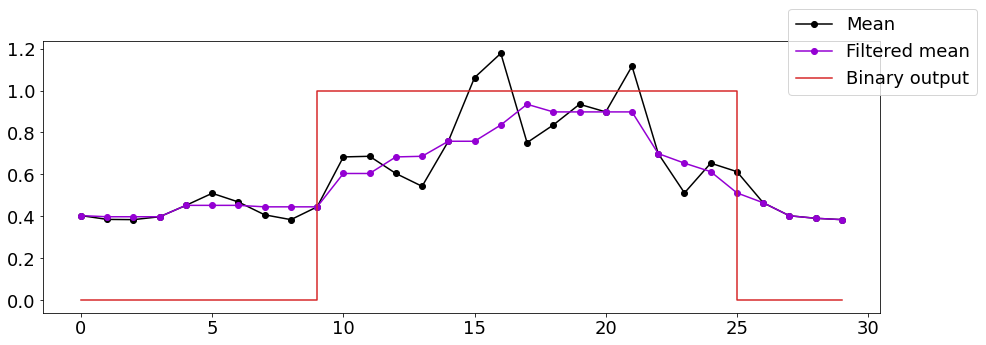

In [133]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(mean_output_data[310:340], 'o-', color='black', label='Mean')
ax.plot(filtered_mean_output[310:340], 'o-', color='darkviolet', label='Filtered mean')
ax.step(filtered_binary_output[310:340], '-', color='tab:red', label='Binary output')

fig.legend()
plt.show()

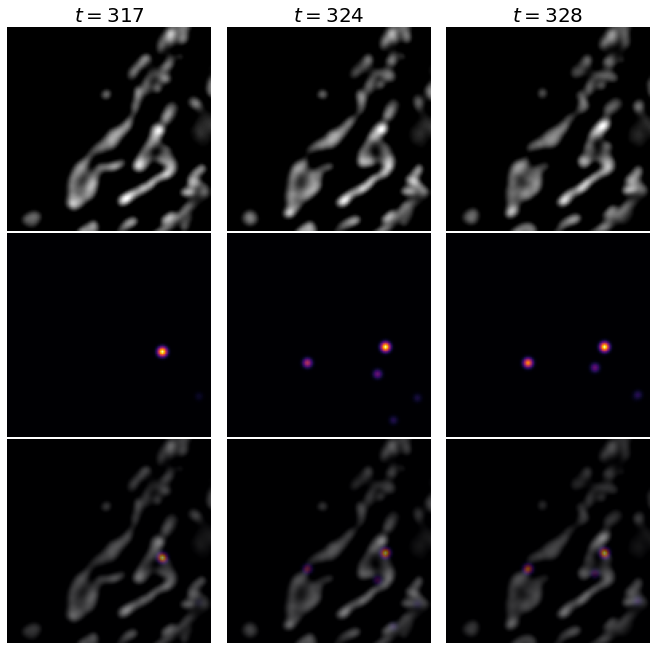

In [144]:
nb_examples = 3
item_id = [317, 324, 328]
size = nb_examples*3
fig, axes = plt.subplots(nb_examples, nb_examples, figsize=(size, size))
for i, frame in enumerate(item_id):
  plot_comparison(input_data[frame], proc_output_data[frame], merge=True, axes=axes[:, i])
  axes[0, i].set_title('$t=%i$'%frame, size=20)
  axes[1, i].set_title('')
  axes[2, i].set_title('')

fig.subplots_adjust(left=0, right=1, top=0.96, bottom=0.01, wspace=0.05, hspace=0.01)
plt.show()
#fig.savefig(new_data_path+'division_example.pdf')

H:/Santi/Figures/ground_truth_t34136.pdf


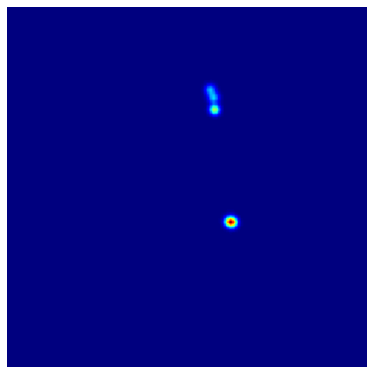

In [202]:
item_id = 34136
cmap = 'jet'
title = 'ground_truth'
title = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(title)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(output_data[item_id], cmap=cmap)
ax.axis('off')
plt.tight_layout(pad=0)
plt.savefig(title)


H:/Santi/Figures/distance_map_t34136.pdf


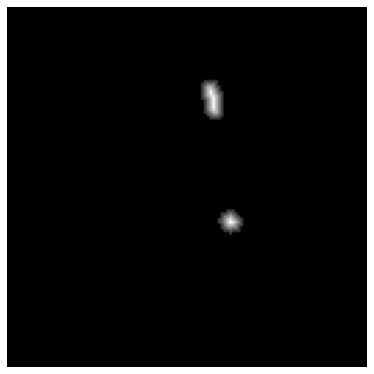

In [203]:
cmap = 'gray'
title = 'distance_map'
title = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(title)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(ndi.distance_transform_edt(output_data[item_id]), cmap=cmap)
ax.axis('off')
plt.tight_layout(pad=0)
plt.savefig(title)

H:/Santi/Figures/watershed_t34136.pdf


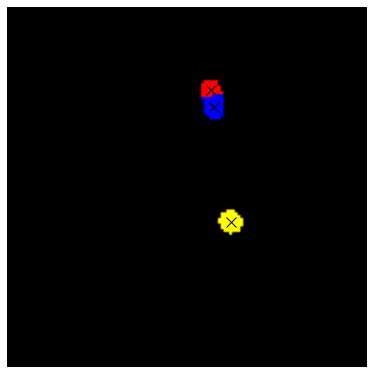

In [237]:
labels = distance_watershed(output_data[item_id])
rp = measure.regionprops(labels)
centroids = np.array([region.centroid for region in rp]).round().astype(int)

title = 'watershed'
title = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(title)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(label2rgb(labels, bg_label=0))
ax.plot(centroids[:, 1], centroids[:, 0], 'x', markersize=10, color='black')
ax.axis('off')
plt.tight_layout(pad=0)
plt.savefig(title)

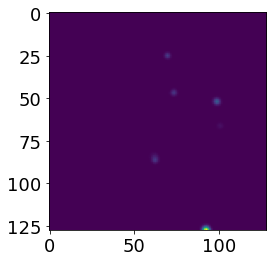

In [213]:
plt.imshow(output_data[31])

H:/Santi/Figures/proc_ground_truth_t34136.pdf


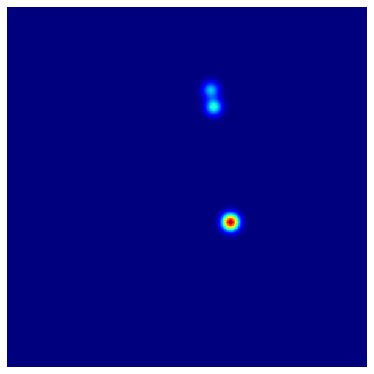

In [205]:
cmap='jet'
title = 'proc_ground_truth'
title = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(title)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(proc_output_data[item_id], cmap=cmap)
ax.axis('off')
plt.tight_layout(pad=0)
plt.savefig(title)